In [30]:
import polars as pl
from typing import List


def rolling_skew_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m3 = ((pl.col(col) - mean) ** 3).rolling_mean(window)
    return (m3 / (std ** 3)).alias(f"{col}_skew")


def rolling_kurt_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m4 = ((pl.col(col) - mean) ** 4).rolling_mean(window)
    return (m4 / (std ** 4)).alias(f"{col}_kurt")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量 = x_t - x_{t-lag}
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_momentum_{lag}")

def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def lag_expr(col: str, lag: int = 200) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def sigmoid_expr(col: str) -> pl.Expr:
    return (1 / (1 + (-pl.col(col)).exp())).alias(f"{col}_sigmoid")

def tanh_expr(col: str) -> pl.Expr:
    return pl.col(col).tanh().alias(f"{col}_tanh")

def boxcox_expr(col: str, lam: float = 0.0) -> pl.Expr:
    # Box-Cox: 当 lam=0时，等同于 log(x + 1)
    # 这里为了安全，先加1避免0或负数
    if lam == 0:
        return (pl.col(col) + 1).log().alias(f"{col}_boxcox_{lam}")
    else:
        return (((pl.col(col) + 1) ** lam - 1) / lam).alias(f"{col}_boxcox_{lam}")

def triple_cross_expr(cols: List[str]) -> List[pl.Expr]:
    exprs = []
    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            for k in range(j + 1, n):
                exprs.append(
                    (pl.col(cols[i]) * pl.col(cols[j]) * pl.col(cols[k]))
                    .alias(f"{cols[i]}_X_{cols[j]}_X_{cols[k]}")
                )
    return exprs

def triple_max_mid_min_expr(cols: List[str]) -> List[pl.Expr]:
    exprs = []
    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            for k in range(j + 1, n):
                max_col = pl.max_horizontal([pl.col(cols[i]), pl.col(cols[j]), pl.col(cols[k])])
                mean_col = pl.mean_horizontal([pl.col(cols[i]), pl.col(cols[j]), pl.col(cols[k])])
                min_col = pl.min_horizontal([pl.col(cols[i]), pl.col(cols[j]), pl.col(cols[k])])
                exprs.append(
                    ((max_col - mean_col) / (mean_col - min_col + 1e-8))
                    .alias(f"{cols[i]}_{cols[j]}_{cols[k]}_max_mean_min_ratio")
                )
    return exprs

def batch_apply_transforms(df: pl.DataFrame, window: int, lag: int, exclude_cols: List[str] = None) -> pl.DataFrame:
    if exclude_cols is None:
        exclude_cols = ['price', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    base_cols = [
        col for col in cols
        if col not in exclude_cols and not (
            col.endswith('_rolling_mean') or
            col.endswith('_rolling_std') or
            col.endswith('_scaled')
        )
    ]

    exprs = []

    # single features transformation
    for col in base_cols:
        exprs.extend([
            rolling_skew_expr(col, window),
            rolling_kurt_expr(col, window),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
            momentum_expr(col, lag),
            momentum_ratio_expr(col, lag),
            lag_expr(col, lag),
            sigmoid_expr(col),
            tanh_expr(col),
            boxcox_expr(col, lam=0),
            (pl.col(col) ** 2).alias(f"{col}_squared"),
            (pl.col(col).sqrt()).alias(f"{col}_sqrt"),
            (pl.col(col).log1p()).alias(f"{col}_log1p"),
        ])

    # double features transformation
    n = len(base_cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = base_cols[i], base_cols[j]
            exprs.extend([
                (pl.col(a) * pl.col(b)).alias(f"{a}_X_{b}"),
                (pl.col(a) / (pl.col(b) + 1e-8)).alias(f"{a}_DIV_{b}"),
                ((pl.col(a) / (pl.col(b) + 1e-8)).log()).alias(f"{a}_LOGR_{b}")
            ])

    # triple features transformation
    exprs.extend(triple_cross_expr(base_cols))
    exprs.extend(triple_max_mid_min_expr(base_cols))

    return df.with_columns(exprs)



In [96]:
df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors__threshold0.0005_rolling200.csv")

timestamp                                                0
price                                                    0
sum_buy_size                                             0
sum_sell_size                                            0
timestamp_duration                                       0
price_pct_change                                         0
buy_sell_imbalance                                       0
trades_side                                              0
change_side                                              0
alt_top_long_short_account_ratio_data_longShortRatio     0
alt_top_long_short_position_ratio_data_longShortRatio    0
alt_trade_taker_long_short_ratio_data_buySellRatio       0
alt_long_short_ratio_data_longShortRatio                 0
alt_open_interest_data_sumOpenInterest                   0
alt_open_interest_data_sumOpenInterestValue              0
alt_factor_short_term_oi_trend                           0
alt_factor_long_term_oi_trend                           

In [62]:
import polars as pl
from typing import List

def split_df_by_week(df: pl.DataFrame, ts_col: str = "timestamp") -> List[pl.DataFrame]:
    # 新增 datetime 列，不覆盖原始时间戳
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])
    
    # 按周截断，用新的 datetime 列
    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    # 获取唯一周
    unique_weeks = df.select("week_start").unique().sort("week_start")

    # 每周筛选子 DataFrame，保留所有列
    weekly_dfs = [
        df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs


In [64]:
# 假设你已有 df
weekly_dataframes = split_df_by_week(df)
print(f"共拆成 {len(weekly_dataframes)} 个周数据帧")


共拆成 7 个周数据帧


In [66]:
print(weekly_dataframes[0])

shape: (3_440, 49)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬──────────────────────┬─────────────────────┬─────────────────────┬──────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ momentum_confirmed_b ┆ oi_long_breakout_si ┆ oi_short_breakout_s ┆ timestamp_dt │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ y_orderflo…          ┆ gnal                ┆ ignal               ┆ ---          │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                  ┆ ---                 ┆ ---                 ┆ datetime[μs] │
│                  ┆         ┆              ┆               ┆   ┆ f64                  ┆ f64                 ┆ f64                 ┆              │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪══════════════════════╪═════════════════════╪═════════════════════╪══════════════╡
│ 1743919408338000 ┆ 83381.5 ┆ 487.007      ┆ 418.752       ┆ … ┆ 0.0                  ┆ 0.02

In [68]:
df = batch_apply_transforms(weekly_dataframes[1], 200, 1)

In [41]:
print(df)
print(df.estimated_size() / (1024 ** 2), "MB")

shape: (39_407, 34_112)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬───────────────────┬───────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ impact_sensitivity ┆ impact_sensitivity ┆ impact_sensitivit ┆ momentum_confirme │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ _momentum_co…      ┆ _momentum_co…      ┆ y_oi_long_bre…    ┆ d_by_orderflo…    │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---               ┆ ---               │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64               ┆ f64               │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 1743984014703000 ┆ 78350.5 ┆ 33.399       ┆ 83.261        ┆ … ┆ 0.498917           ┆ 0

In [84]:
print(df)

# 打印 Polars DataFrame 占用内存（MB）
print(f"Polars DataFrame size: {df.estimated_size() / (1024 ** 2):.4f} MB")

# 转成 Pandas DataFrame
pdf = df.to_pandas()

# 打印 Pandas DataFrame 的内存占用（MB）
print(f"Pandas DataFrame size: {pdf.memory_usage(deep=True).sum() / (1024 ** 2):.4f} MB")

shape: (39_407, 34_112)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬───────────────────┬───────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ impact_sensitivity ┆ impact_sensitivity ┆ impact_sensitivit ┆ momentum_confirme │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ _momentum_co…      ┆ _momentum_co…      ┆ y_oi_long_bre…    ┆ d_by_orderflo…    │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---               ┆ ---               │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64               ┆ f64               │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 1743984014703000 ┆ 78350.5 ┆ 33.399       ┆ 83.261        ┆ … ┆ 0.498917           ┆ 0

In [93]:
import pandas as pd

# 假设 pdf 是你的 pandas DataFrame

# 查看每列空值数量
null_counts = pdf.isnull().sum()
print(null_counts)

# 或者只显示有空值的列
print(null_counts[null_counts > 0])
cols_to_drop = null_counts[null_counts > 1000].index

# 删除这些列
pdf_cleaned = pdf.drop(columns=cols_to_drop)

# print(f"删除了这些列：{list(cols_to_drop)}")
print(f"清理后DataFrame形状：{pdf_cleaned.shape}")
# 👇 查看空值最多的列
max_null_col = null_counts.idxmax()
max_null_count = null_counts.max()
print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")

timestamp                                                                                              0
price                                                                                                  0
sum_buy_size                                                                                           0
sum_sell_size                                                                                          0
timestamp_duration                                                                                     0
                                                                                                      ..
impact_momentum_oi_long_breakout_signal_oi_short_breakout_signal_max_mean_min_ratio                    0
impact_sensitivity_momentum_confirmed_by_orderflow_oi_long_breakout_signal_max_mean_min_ratio          0
impact_sensitivity_momentum_confirmed_by_orderflow_oi_short_breakout_signal_max_mean_min_ratio         0
impact_sensitivity_oi_long_breakout_signal_oi_short_bre

In [99]:
pdf_clean = pdf_cleaned.dropna()

# 转成 Polars DataFrame
df = pl.from_pandas(pdf_clean)
print(df)

shape: (38_571, 33_472)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬───────────────────┬───────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ impact_sensitivity ┆ impact_sensitivity ┆ impact_sensitivit ┆ momentum_confirme │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ _momentum_co…      ┆ _momentum_co…      ┆ y_oi_long_bre…    ┆ d_by_orderflo…    │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---               ┆ ---               │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64               ┆ f64               │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 1743988103953000 ┆ 78636.3 ┆ 16.591       ┆ 9.189         ┆ … ┆ 1.542089           ┆ 1

In [86]:
import numpy as np
from tqdm import tqdm

def avg_steps_to_volatility_median(prices: np.ndarray, target_ratio: float) -> float:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.median(steps_list))

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> float:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

prices_np = pdf["price"].to_numpy()
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)  # 波动1%
print("波动 ±0.5% 的均值步数:", avg_steps_05pct)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)  # 波动1%
print("波动 ±1% 的均值步数:", avg_steps_1pct)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02)  # 波动1%
print("波动 ±2% 的均值步数:", avg_steps_2pct)

avg_steps_05pct_median = avg_steps_to_volatility_median(prices_np, 0.005)  # 波动1%
print("波动 ±0.5% 的中位步数:", avg_steps_05pct_median)
avg_steps_1pct_median = avg_steps_to_volatility_median(prices_np, 0.01)  # 波动1%
print("波动 ±1% 的中位步数:", avg_steps_1pct_median)
avg_steps_2pct_median = avg_steps_to_volatility_median(prices_np, 0.02)  # 波动1%
print("波动 ±2% 的中位步数:", avg_steps_2pct_median)

cal abs change 0.50% avg steps: 100%|████████████████████████████████████████████████████████████████████| 39407/39407 [00:00<00:00, 50778.16it/s]


波动 ±0.5% 的均值步数: 109


cal abs change 1.00% avg steps: 100%|████████████████████████████████████████████████████████████████████| 39407/39407 [00:02<00:00, 14867.71it/s]


波动 ±1% 的均值步数: 377


cal abs change 2.00% avg steps: 100%|█████████████████████████████████████████████████████████████████████| 39407/39407 [00:09<00:00, 4306.85it/s]


波动 ±2% 的均值步数: 1312


cal abs change 0.50% avg steps: 100%|████████████████████████████████████████████████████████████████████| 39407/39407 [00:00<00:00, 50943.54it/s]


波动 ±0.5% 的中位步数: 77


cal abs change 1.00% avg steps: 100%|████████████████████████████████████████████████████████████████████| 39407/39407 [00:02<00:00, 14926.42it/s]


波动 ±1% 的中位步数: 306


cal abs change 2.00% avg steps: 100%|█████████████████████████████████████████████████████████████████████| 39407/39407 [00:09<00:00, 4319.80it/s]

波动 ±2% 的中位步数: 1119


In [102]:
def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

In [104]:
df = df.with_columns([
    future_return_expr("price", avg_steps_05pct),
    future_return_expr("price", avg_steps_1pct),
    future_return_expr("price", avg_steps_2pct),
])

In [128]:
import pandas as pd

# 假设 pdf 是你的 pandas DataFrame
pdf = df.to_pandas()

# 查看每列空值数量
null_counts = pdf.isnull().sum()
print(null_counts)

# 或者只显示有空值的列
print(null_counts[null_counts > 0])
cols_to_drop = null_counts[null_counts > 10000].index

# 删除这些列
pdf_cleaned = pdf.drop(columns=cols_to_drop)

print(f"删除了这些列：{list(cols_to_drop)}")
print(f"清理后DataFrame形状：{pdf_cleaned.shape}")

pdf_clean = pdf_cleaned.dropna()

# 转成 Polars DataFrame
df = pl.from_pandas(pdf_clean)
print(df)

timestamp                                                                                                 0
price                                                                                                     0
sum_buy_size                                                                                              0
sum_sell_size                                                                                             0
timestamp_duration                                                                                        0
                                                                                                       ... 
impact_sensitivity_oi_long_breakout_signal_oi_short_breakout_signal_max_mean_min_ratio                    0
momentum_confirmed_by_orderflow_oi_long_breakout_signal_oi_short_breakout_signal_max_mean_min_ratio       0
future_return_109                                                                                       109
future_return_377           

In [106]:
def future_timestamp_sum_duration_expr(ts_col: str, step: int) -> pl.Expr:
    return (
        pl.col(ts_col)
        .diff()
        .shift(-step + 1)
        .rolling_sum(window_size=step)
        .alias(f"future_duration_sum_{step}")
    )
    
df_ts = df.with_columns([
    future_timestamp_sum_duration_expr("timestamp", avg_steps_05pct),
    future_timestamp_sum_duration_expr("timestamp", avg_steps_1pct),
    future_timestamp_sum_duration_expr("timestamp", avg_steps_2pct),
])

df_ts = df_ts.slice(1)  # 跟 df 一致
df_ts = df_ts.select([
    f"future_duration_sum_{int(avg_steps_05pct)}",
    f"future_duration_sum_{int(avg_steps_1pct)}",
    f"future_duration_sum_{int(avg_steps_2pct)}",
    "timestamp_duration",
]).drop_nulls()

In [108]:
df_ts.describe()

statistic,future_duration_sum_109,future_duration_sum_377,future_duration_sum_1312,timestamp_duration
str,f64,f64,f64,f64
"""count""",35949.0,35949.0,35949.0,35949.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",1.6446e9,5.7599e9,2.0516e10,1.4321e7
"""std""",2.3267e9,7.1816e9,1.9789e10,3.3380e7
"""min""",3000.0,748000.0,1.43084e8,0.0
"""25%""",1.50397e8,9.57001e8,5.4487e9,308000.0
"""50%""",8.21762e8,3.4377e9,1.4785e10,3.383e6
"""75%""",1.9161e9,6.6396e9,2.8765e10,1.327e7
"""max""",1.5274e10,3.9200e10,8.5498e10,8.5147e8


In [47]:
2.0138e10		 / 1000000 / 3600

5.5938888888888885

In [48]:
def fast_spearman_ic(df: pl.DataFrame, target_col: str = "future_return_200") -> dict:
    exclude_prefixes = ['price', 'timestamp', 'timestamp_dt', 'symbol']
    exclude_prefixes += [col for col in df.columns if col.startswith("future_return_")]

    feature_cols = [col for col in df.columns if col not in exclude_prefixes]

    ic_dict = {}

    rank_cols = feature_cols + [target_col]
    df_ranked = df.with_columns([
        pl.col(col).rank(method="average").alias(col + "_rank") for col in rank_cols
    ])

    target_rank = target_col + "_rank"

    for feat in tqdm(feature_cols, desc="Calculating IC"):
        feat_rank = feat + "_rank"
        corr = df_ranked.select(
            pl.corr(pl.col(feat_rank), pl.col(target_rank)).alias("corr")
        ).to_series()[0]
        ic_dict[feat] = corr

    return ic_dict

In [80]:
print(df.shape)
print(df.head())

(39407, 34112)
shape: (5, 34_112)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬───────────────────┬───────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ impact_sensitivity ┆ impact_sensitivity ┆ impact_sensitivit ┆ momentum_confirme │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ _momentum_co…      ┆ _momentum_co…      ┆ y_oi_long_bre…    ┆ d_by_orderflo…    │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---               ┆ ---               │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64               ┆ f64               │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 1743984014703000 ┆ 78350.5 ┆ 33.399       ┆ 83.261        ┆ … ┆ 0.498917    

In [130]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_05pct}")

KeyboardInterrupt: 

In [ ]:
# 按 IC 值排序（降序）
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in sorted_ic[-20:]:
    print(f"{feat}: {ic:.6f}")


In [ ]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_1pct}")

In [ ]:
# 按 IC 值排序（降序）
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in sorted_ic[-20:]:
    print(f"{feat}: {ic:.6f}")


In [131]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_2pct}")

Calculating IC: 100%|███████████████████████████████████████████████████████████████████████████████████████| 33469/33469 [06:43<00:00, 83.01it/s]


In [132]:
# 按 IC 值排序（降序）
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in sorted_ic[-20:]:
    print(f"{feat}: {ic:.6f}")


Top 20 features by IC:
alt_factor_long_term_oi_trend_DIV_far_ask_price: 0.401659
alt_factor_long_term_oi_trend_LOGR_far_ask_price: 0.401659
far_ask_price_DIV_factor_px_oi_divergence: 0.401604
alt_factor_long_term_oi_trend_DIV_best_ask_price: 0.401025
alt_factor_long_term_oi_trend_LOGR_best_ask_price: 0.401025
best_ask_price_DIV_factor_px_oi_divergence: 0.400875
alt_factor_long_term_oi_trend_DIV_mid_price: 0.400586
alt_factor_long_term_oi_trend_LOGR_mid_price: 0.400586
mid_price_DIV_factor_px_oi_divergence: 0.400428
alt_factor_long_term_oi_trend_DIV_best_bid_price: 0.400218
alt_factor_long_term_oi_trend_LOGR_best_bid_price: 0.400218
best_bid_price_DIV_factor_px_oi_divergence: 0.400093
alt_factor_long_term_oi_trend_DIV_far_bid_price: 0.399133
alt_factor_long_term_oi_trend_LOGR_far_bid_price: 0.399133
far_bid_price_DIV_factor_px_oi_divergence: 0.399048
alt_open_interest_data_sumOpenInterest_DIV_far_ask_price: 0.372864
alt_open_interest_data_sumOpenInterest_LOGR_far_ask_price: 0.372864
alt

In [137]:
pdf_clean = df.to_pandas()


In [141]:
from scipy.stats import spearmanr
# 替换为你的目标收益列名
target_col = f"future_return_{avg_steps_2pct}"
factor_col = "alt_factor_long_term_oi_trend_far_ask_price_factor_px_oi_divergence_max_mean_min_ratio"

# 取出非空值（NaN 会自动剔除）
series1 = pdf_clean[factor_col]
series2 = pdf_clean[target_col]
print(series1.isna().sum(), series2.isna().sum())

# 计算 Spearman 相关系数
ic, pval = spearmanr(series1, series2)

print(f"Spearman IC: {ic:.6f}, p-value: {pval:.6g}")


0 0
Spearman IC: -0.401672, p-value: 0


In [161]:
def calc_hourly_rankic(
    df: pl.DataFrame,
    timestamp_col: str,
    target_col: str,
    exclude_cols: list[str] = None,
    factor_prefix_exclude: str = "future_return_"
) -> pl.DataFrame:

    if exclude_cols is None:
        exclude_cols = []

    factor_cols = [
        col for col in df.columns
        if col not in exclude_cols and not col.startswith(factor_prefix_exclude)
    ]

    # 微秒时间戳转换成datetime
    df = df.with_columns(
        pl.col(timestamp_col).cast(pl.Int64).cast(pl.Datetime("us"))
    )

    # 截断到小时
    df = df.with_columns(
        pl.col(timestamp_col).dt.truncate("1h").alias("hour_group")
    )

    group = df.group_by("hour_group")

    agg_exprs = []
    for factor in factor_cols:
        agg_exprs.append(
            pl.corr(pl.col(factor).rank(method="average"), pl.col(target_col).rank(method="average"), method="spearman").alias(factor)
        )

    ic_df = group.agg(agg_exprs)

    return ic_df


In [202]:
def summarize_ic_df_wide(ic_df: pl.DataFrame, exclude_prefixes: list[str] = None) -> pl.DataFrame:
    if exclude_prefixes is None:
        exclude_prefixes = []

    factor_cols = [
        col for col in ic_df.columns
        if all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "price"
    ]

    data = []
    for factor in tqdm(factor_cols, desc="Calculating IC stats"):
        mean_ic = ic_df.select(pl.col(factor).mean()).item()
        std_ic = ic_df.select(pl.col(factor).std()).item()
        ir = mean_ic / std_ic if std_ic and std_ic != 0 else None
        data.append({"factor": factor, "mean_ic": mean_ic, "std_ic": std_ic, "ir": ir})
    
    return pl.DataFrame(data)

result = summarize_ic_df_wide(ic_hourly, exclude_cols)
print(result)


Calculating IC stats: 100%|████████████████████████████████████████████████████████████████████████████████| 31537/31537 [01:22<00:00, 380.61it/s]

shape: (31_537, 4)
┌─────────────────────────────────┬───────────┬──────────┬───────────┐
│ factor                          ┆ mean_ic   ┆ std_ic   ┆ ir        │
│ ---                             ┆ ---       ┆ ---      ┆ ---       │
│ str                             ┆ f64       ┆ f64      ┆ f64       │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════╡
│ sum_buy_size                    ┆ -0.049473 ┆ 0.191089 ┆ -0.2589   │
│ sum_sell_size                   ┆ 0.059827  ┆ 0.177968 ┆ 0.336167  │
│ price_pct_change                ┆ -0.089918 ┆ 0.107867 ┆ -0.833596 │
│ buy_sell_imbalance              ┆ -0.129057 ┆ 0.174647 ┆ -0.738961 │
│ trades_side                     ┆ -0.100088 ┆ 0.140043 ┆ -0.714693 │
│ …                               ┆ …         ┆ …        ┆ …         │
│ impact_momentum_oi_long_breako… ┆ 0.184797  ┆ 0.304881 ┆ 0.606129  │
│ impact_sensitivity_momentum_co… ┆ -0.087219 ┆ 0.175474 ┆ -0.497046 │
│ impact_sensitivity_momentum_co… ┆ -0.194321 ┆ 0.208309 ┆

In [ ]:
df

In [ ]:
def print_top_bottom_ic_ir_with_values(df: pl.DataFrame, top_n: int = 20):
    # drop NaNs
    pdf = df.to_pandas()
    pdf = pdf.dropna(subset=["mean_ic", "ir"])
    pdf = pdf[ pdf["mean_ic"].abs() > ic_abs_threshold ]

    df_filtered = pl.from_pandas(pdf)

    def format_rows(rows, metric_name):
        max_len = max(len(row["factor"]) for row in rows)
        return [
            f"{i+1:>2}. {row['factor']:<{max_len}}  {metric_name}: {row[metric_name]:.6f}"
            for i, row in enumerate(rows)
        ]

    ic_top_rows = df_filtered.sort("mean_ic", descending=True).head(top_n).to_dicts()
    ic_bottom_rows = df_filtered.sort("mean_ic").head(top_n).to_dicts()
    ir_top_rows = df_filtered.sort("ir", descending=True).head(top_n).to_dicts()
    ir_bottom_rows =df_filtereddf.sort("ir").head(top_n).to_dicts()

    print("📈 Top IC Factors:")
    print("\n".join(format_rows(ic_top_rows, "mean_ic")), end="\n\n")

    print("📉 Bottom IC Factors:")
    print("\n".join(format_rows(ic_bottom_rows, "mean_ic")), end="\n\n")

    print("📈 Top IR Factors:")
    print("\n".join(format_rows(ir_top_rows, "ir")), end="\n\n")

    print("📉 Bottom IR Factors:")
    print("\n".join(format_rows(ir_bottom_rows, "ir")), end="\n\n")

    factor_list = pdf['factor'].tolist()
    return factor_list

factors_selected = print_top_bottom_ic_ir_with_values(result, top_n=20, ic_abs_threshold=0.1)
print(factors_selected)


In [246]:
import polars as pl
import pandas as pd
import re

def get_factor_core_name(factor_name):
    core = re.split(r'(_DIV_|_LOGR_|_X_)', factor_name)[0]
    return core

def deduplicate_with_core(df: pl.DataFrame, metric='mean_ic'):
    pdf = df.to_pandas()
    pdf['core_factor'] = pdf['factor'].apply(get_factor_core_name)
    # 先排序保证取最大metric时是对应的行
    pdf = pdf.sort_values(metric, ascending=False)
    # 取每个core_factor表现最好的那条
    pdf = pdf.drop_duplicates(subset=['core_factor'])
    return pl.from_pandas(pdf)

def print_top_bottom_ic_ir_with_core(df: pl.DataFrame, top_n: int = 20):
    def format_rows(rows, metric_name):
        max_len = max(len(row["factor"]) for row in rows)
        return [
            f"{i+1:>2}. {row['factor']:<{max_len}} ({row['core_factor']})  {metric_name}: {row[metric_name]:.6f}"
            for i, row in enumerate(rows)
        ]

    pdf = df.to_pandas()
    pdf = pdf.dropna(subset=["mean_ic", "ir"])

    ic_top_rows = pdf.sort_values("mean_ic", ascending=False).head(top_n).to_dict(orient='records')
    ic_bottom_rows = pdf.sort_values("mean_ic", ascending=True).head(top_n).to_dict(orient='records')
    ir_top_rows = pdf.sort_values("ir", ascending=False).head(top_n).to_dict(orient='records')
    ir_bottom_rows = pdf.sort_values("ir", ascending=True).head(top_n).to_dict(orient='records')

    print("📈 Top IC Factors:")
    print("\n".join(format_rows(ic_top_rows, "mean_ic")), end="\n\n")

    print("📉 Bottom IC Factors:")
    print("\n".join(format_rows(ic_bottom_rows, "mean_ic")), end="\n\n")

    print("📈 Top IR Factors:")
    print("\n".join(format_rows(ir_top_rows, "ir")), end="\n\n")

    print("📉 Bottom IR Factors:")
    print("\n".join(format_rows(ir_bottom_rows, "ir")), end="\n\n")

# 去重示例
df_dedup = deduplicate_with_core(result, metric='mean_ic')
print_top_bottom_ic_ir_with_core(df_dedup, top_n=20)


📈 Top IC Factors:
 1. alt_factor_long_term_oi_trend_LOGR_best_ask_price                                                            (alt_factor_long_term_oi_trend)  mean_ic: 0.574623
 2. far_ask_price_DIV_factor_px_oi_divergence                                                                    (far_ask_price)  mean_ic: 0.574317
 3. mid_price_DIV_factor_px_oi_divergence                                                                        (mid_price)  mean_ic: 0.573873
 4. best_ask_price_DIV_factor_px_oi_divergence                                                                   (best_ask_price)  mean_ic: 0.573582
 5. far_bid_price_DIV_factor_px_oi_divergence                                                                    (far_bid_price)  mean_ic: 0.573473
 6. best_bid_price_DIV_factor_px_oi_divergence                                                                   (best_bid_price)  mean_ic: 0.572858
 7. alt_open_interest_data_sumOpenInterestValue_alt_factor_long_term_oi_trend_be

In [ ]:
def remove_high_corr_factors(factor_values_df: pl.DataFrame, factor_metrics_df: pl.DataFrame,
                             corr_threshold=0.85, metric='mean_ic'):
    # 转 pandas 计算相关性
    pdf_values = factor_values_df.to_pandas()

    # 因子名字列表
    factors = list(pdf_values.columns)

    # 计算相关矩阵
    corr = pdf_values.corr().abs()

    # 只遍历上三角矩阵
    to_remove = set()
    for i in tqdm(range(len(factors)), desc="Outer loop"):
        for j in range(i + 1, len(factors)):
            f1 = factors[i]
            f2 = factors[j]
            if corr.loc[f1, f2] >= corr_threshold:
                # 找表现差的因子剔除
                score1 = factor_metrics_df.filter(pl.col('factor') == f1)[metric].item()
                score2 = factor_metrics_df.filter(pl.col('factor') == f2)[metric].item()
                if score1 >= score2:
                    to_remove.add(f2)
                else:
                    to_remove.add(f1)

    # 剔除高相关且表现差的因子
    filtered_factors = [f for f in factors if f not in to_remove]
    print(f"剔除 {len(to_remove)} 个因子，剩余 {len(filtered_factors)} 个因子")

    return filtered_factors



if exclude_prefixes is None:
    exclude_prefixes = []

all_factors  = [
    col for col in ic_df.columns
    if all(not col.startswith(prefix) for prefix in exclude_prefixes)
    and not col.startswith("future_return_")
    and col != "price"
]
filtered_factors = remove_high_corr_factors(df, result, corr_threshold=0.85, metric='mean_ic')

print(f"最终保留的因子数：{len(filtered_factors)}")


In [163]:
# 你的 pl.DataFrame 设为 df
target_col = f"future_return_{avg_steps_2pct}"
# pl_ic_df = calc_spearman_ic_polars_clean(df, target_col=target_col)

# print(pl_ic_df)  # 每小时每因子的 IC

exclude_cols = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group']

ic_hourly = calc_hourly_rankic(
    df,
    timestamp_col="timestamp",
    target_col=target_col,
    exclude_cols=exclude_cols
)

print(ic_hourly)


shape: (156, 33_471)
┌──────────────┬───────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ hour_group   ┆ price     ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ impact_sensitivity ┆ impact_sensitivity ┆ impact_sensitivity ┆ momentum_confirmed │
│ ---          ┆ ---       ┆ ---          ┆ ---           ┆   ┆ _momentum_co…      ┆ _momentum_co…      ┆ _oi_long_bre…      ┆ _by_orderflo…      │
│ datetime[μs] ┆ f64       ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---                ┆ ---                │
│              ┆           ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64                ┆ f64                │
╞══════════════╪═══════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 2025-04-07   ┆ -0.59513  ┆ 0.069625     ┆ 0.006071      ┆ … ┆ -0.006265          ┆ 0.0590

In [ ]:
result = summarize_ic_df(ic_hourly)
print(result)

In [179]:
ic_hourly = ic_hourly.sort("hour_group")
print(ic_hourly)

shape: (156, 33_471)
┌──────────────┬───────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ hour_group   ┆ price     ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ impact_sensitivity ┆ impact_sensitivity ┆ impact_sensitivity ┆ momentum_confirmed │
│ ---          ┆ ---       ┆ ---          ┆ ---           ┆   ┆ _momentum_co…      ┆ _momentum_co…      ┆ _oi_long_bre…      ┆ _by_orderflo…      │
│ datetime[μs] ┆ f64       ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---                ┆ ---                │
│              ┆           ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64                ┆ f64                │
╞══════════════╪═══════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 2025-04-07   ┆ -0.96844  ┆ -0.205731    ┆ -0.106344     ┆ … ┆ -0.133104          ┆ -0.277

In [ ]:
def get_max_ic_value(ic_df: pl.DataFrame) -> float:
    print(ic_df)
    exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group']
    # 过滤列名，保留含有 price 的列（比如 ask_price）
    factor_cols = [
        col for col in ic_df.columns
        if all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "price"  # 如果有完全叫 price 的列排除
    ]
    # 逐列取最大值，然后再取这些列最大
    max_values = ic_df.select(factor_cols)
    return max_values

max_ic = get_max_ic_value(pl_ic_df)
print(f"Max IC value in whole ic_df: {max_ic:.6f}")


In [ ]:
stats_df = summarize_ic_df(pl_ic_df)
print(stats_df.head(5))  # 最有效因子


In [ ]:
def classify_ic_ir_cols(cols):
    """
    分类以 `_ic` 和 `_ir` 结尾的列，返回两个字典：
    ic_cols: {factor_name: full_col_name}
    ir_cols: {factor_name: full_col_name}
    """
    ic_cols = {}
    ir_cols = {}

    for col in cols:
        if col.endswith("_ic"):
            factor = col[:-3]
            ic_cols[factor] = col
        elif col.endswith("_ir"):
            factor = col[:-3]
            ir_cols[factor] = col

    return ic_cols, ir_cols

def extract_ic_ir_data(df: pl.DataFrame):
    ic_cols, ir_cols = classify_ic_ir_cols(df.columns)

    # 只提取每列的第一个元素（通常只有一行）
    ic_data = {factor: df[col][0] for factor, col in ic_cols.items()}
    ir_data = {factor: df[col][0] for factor, col in ir_cols.items()}

    return ic_cols, ir_cols, ic_data, ir_data

def print_top_bottom_ic(ic_results: dict, top_n=20):
    # 按 IC 降序排序
    sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

    print(f"Top {top_n} features by IC:")
    for feat, ic in sorted_ic[:top_n]:
        print(f"{feat}: {ic:.6f}")

    print(f"\nBottom {top_n} features by IC:")
    for feat, ic in sorted_ic[-top_n:]:
        print(f"{feat}: {ic:.6f}")

def print_top_bottom_ir(ir_results: dict, top_n=20):
    sorted_ir = sorted(ir_results.items(), key=lambda x: x[1], reverse=True)

    print(f"\nTop {top_n} features by IR:")
    for feat, ir in sorted_ir[:top_n]:
        print(f"{feat}: {ir:.6f}")

    print(f"\nBottom {top_n} features by IR:")
    for feat, ir in sorted_ir[-top_n:]:
        print(f"{feat}: {ir:.6f}")


In [ ]:
ic_cols, ir_cols, ic_dict, ir_dict = extract_ic_ir_data(stats_df)
print_top_bottom_ic(ic_dict)
print_top_bottom_ir(ir_dict)


In [234]:
print(ic_hourly.select("far_bid_price_DIV_factor_px_oi_divergence"))


shape: (156, 1)
┌─────────────────────────────────┐
│ far_bid_price_DIV_factor_px_oi… │
│ ---                             │
│ f64                             │
╞═════════════════════════════════╡
│ 0.968042                        │
│ 0.950341                        │
│ 0.70133                         │
│ 0.616074                        │
│ 0.698697                        │
│ …                               │
│ 0.665664                        │
│ 0.508306                        │
│ 0.269231                        │
│ 0.719799                        │
│ 0.6                             │
└─────────────────────────────────┘


In [236]:
target_col = f"future_return_{avg_steps_2pct}"
x_col = 'far_bid_price_DIV_factor_px_oi_divergence'

df_cleaned_for_icir = df.drop_nulls(subset=[x_col, target_col, 'timestamp'])

icir_df = df_cleaned_for_icir.select([x_col, target_col, 'timestamp']).to_pandas()
print(icir_df)

       far_bid_price_DIV_factor_px_oi_divergence  future_return_1312  \
0                                      -1.077599           -0.027302   
1                                      -1.077069           -0.027848   
2                                      -1.076479           -0.026322   
3                                      -1.075973           -0.026870   
4                                      -1.076487           -0.026326   
...                                          ...                 ...   
37254                                  -1.050628           -0.008822   
37255                                  -1.050212           -0.008821   
37256                                  -1.050713           -0.008818   
37257                                  -1.051255           -0.009816   
37258                                  -1.050740           -0.009819   

              timestamp  
0      1743988103953000  
1      1743988109683000  
2      1743988117612000  
3      1743988127362000  
4    

In [238]:
import pandas as pd

icir_df['timestamp'] = pd.to_datetime(icir_df['timestamp'], unit='us')
icir_df = icir_df.sort_values('timestamp').set_index('timestamp').dropna()


                         far_bid_price_DIV_factor_px_oi_divergence  \
timestamp                                                            
2025-04-07 01:08:23.953                                  -1.077599   
2025-04-07 01:08:29.683                                  -1.077069   
2025-04-07 01:08:37.612                                  -1.076479   
2025-04-07 01:08:47.362                                  -1.075973   
2025-04-07 01:09:02.162                                  -1.076487   
...                                                            ...   
2025-04-13 12:00:13.064                                  -1.050628   
2025-04-13 12:00:58.368                                  -1.050212   
2025-04-13 12:01:26.984                                  -1.050713   
2025-04-13 12:01:53.349                                  -1.051255   
2025-04-13 12:02:49.820                                  -1.050740   

                         future_return_1312  
timestamp                                  

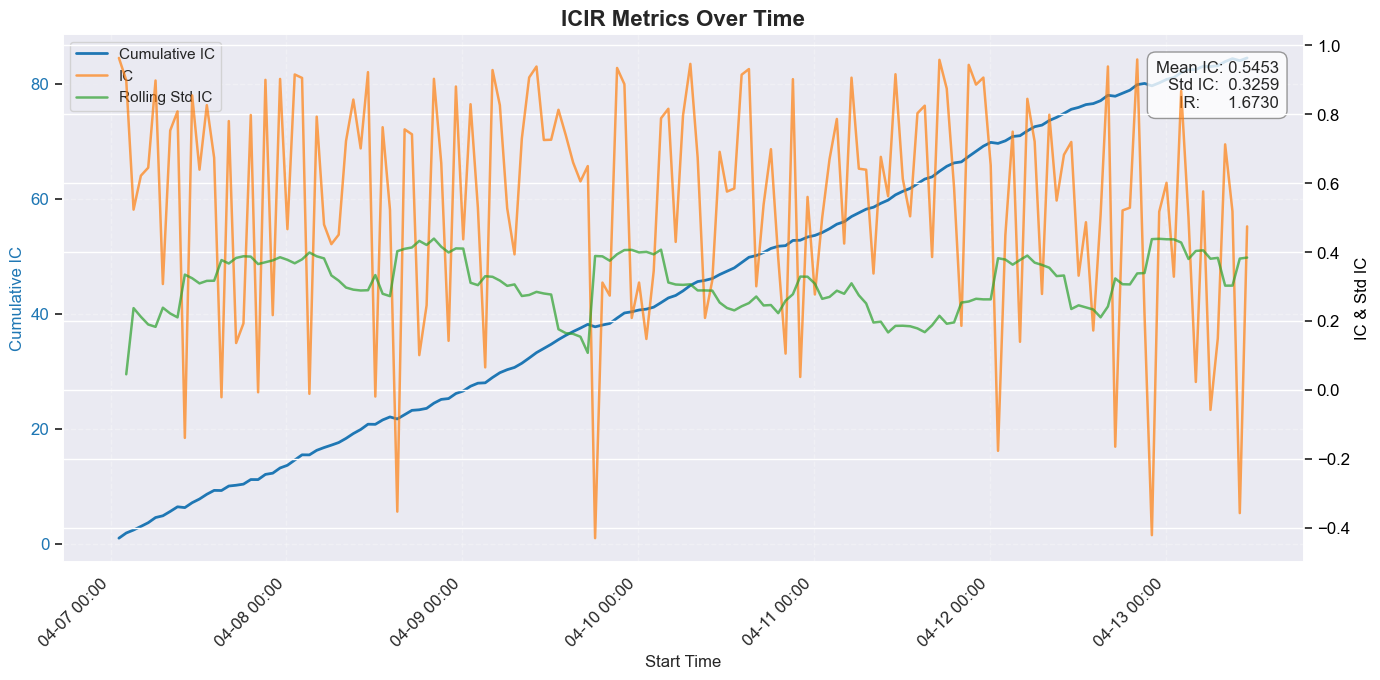

In [240]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns

def calc_ic(df, x_col, target_col):
    # 用斯皮尔曼相关计算IC
    if len(df) < 2:
        return np.nan
    corr, _ = spearmanr(df[x_col], df[target_col], nan_policy='omit')
    return corr

print(icir_df)


hourly_starts = pd.date_range(start=icir_df.index.min(), end=icir_df.index.max(), freq='1h')

ic_list = []

for start_time in hourly_starts:
    end_time = start_time + pd.Timedelta('1h')
    window_df = icir_df[start_time:end_time]
    ic = calc_ic(window_df, x_col, target_col)
    ic_list.append({'start_time': start_time, 'ic': ic})

ic_df = pd.DataFrame(ic_list).dropna()
print(ic_df)
print(ic_hourly.select(x_col))
print("Pandas IC DataFrame 列均值：")
print(ic_df.mean(numeric_only=True))
mean_val = ic_hourly.select(
    pl.col(x_col).mean()
)
print("Polars 中指定列的均值：")
print(mean_val)

mean_ic = ic_df['ic'].mean()
std_ic = ic_df['ic'].std()
ir = mean_ic / std_ic if std_ic != 0 else np.nan

print(f"Mean IC: {mean_ic:.4f}")
print(f"Std IC:  {std_ic:.4f}")
print(f"IR:      {ir:.4f}")
ic_df['cum_ic'] = ic_df['ic'].cumsum()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-muted')  # 更现代清爽的配色
sns.set(font_scale=1.1)

fig, ax1 = plt.subplots(figsize=(14, 7))

# 画累积IC（蓝色）
ax1.plot(ic_df['start_time'], ic_df['cum_ic'], color='#1f77b4', linewidth=2, label='Cumulative IC')
ax1.set_xlabel('Start Time', fontsize=12)
ax1.set_ylabel('Cumulative IC', color='#1f77b4', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.grid(True, which='both', linestyle='--', alpha=0.3)

# 时间格式化，方便显示
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate(rotation=45)

# 右侧y轴画即时IC和滚动Std IC
ax2 = ax1.twinx()
ax2.plot(ic_df['start_time'], ic_df['ic'], color='#ff7f0e', alpha=0.7, linewidth=1.8, label='IC')
rolling_std = ic_df['ic'].rolling(window=10, min_periods=1).std()
ax2.plot(ic_df['start_time'], rolling_std, color='#2ca02c', alpha=0.7, linewidth=1.8, label='Rolling Std IC')
ax2.set_ylabel('IC & Std IC', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# 合并图例
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=11)

# 在图上加文本信息标注
textstr = '\n'.join((
    f"Mean IC: {mean_ic:.4f}",
    f"Std IC:  {std_ic:.4f}",
    f"IR:      {ir:.4f}",
))
# 放在图表右上角，带有半透明背景
props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray')
ax1.text(0.98, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=props)

plt.title('ICIR Metrics Over Time', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
import polars as pl
df = df.drop_nulls()
# 1. 添加 signal 列

factor_col = "spread_skew"

qcut_20 = df.select(pl.col(factor_col).quantile(0.2)).item()
qcut_80 = df.select(pl.col(factor_col).quantile(0.8)).item()

df = df.with_columns([
    pl.when(pl.col(factor_col) >= qcut_80).then(1)
      .when(pl.col(factor_col) <= qcut_20).then(-1)
      .otherwise(0)
      .alias("signal")
])

print("After adding signal column:")
print(df.select([factor_col, "signal"]).tail(10))

# 2. 计算策略收益 = 信号 * 未来收益
df = df.with_columns([
    (pl.col("signal") * pl.col(target_col)).alias("strategy_return")
])

print("After calculating strategy_return:")
print(df.select(["signal", target_col, "strategy_return"]).tail(10))

# 3. 计算累计策略收益
df = df.with_columns([
    pl.col("strategy_return").fill_null(0).cum_sum().alias("cum_strategy_return")
])

print("After calculating cum_strategy_return:")
print(df.select(["strategy_return", "cum_strategy_return"]).tail(10))


In [250]:
df

timestamp,price,sum_buy_size,sum_sell_size,timestamp_duration,price_pct_change,buy_sell_imbalance,trades_side,change_side,alt_top_long_short_account_ratio_data_longShortRatio,alt_top_long_short_position_ratio_data_longShortRatio,alt_trade_taker_long_short_ratio_data_buySellRatio,alt_long_short_ratio_data_longShortRatio,alt_open_interest_data_sumOpenInterest,alt_open_interest_data_sumOpenInterestValue,alt_factor_short_term_oi_trend,alt_factor_long_term_oi_trend,impact_price_pct_ask_imn,impact_price_pct_bid_imn,mid_price,spread,far_bid_price,far_ask_price,best_bid_price,best_ask_price,best_bid_amount,best_ask_amount,real_bid_amount_sum,real_ask_amount_sum,rolling_px_pct_sum,ret_1,ret_1_lag,ret_mean_5,ret_mean_10,volatility_10,buy_sell_ratio,avg_buy_size_10,…,factor_px_oi_divergence_factor_momentum_volume_impact_sensitivity_max_mean_min_ratio,factor_px_oi_divergence_factor_momentum_volume_momentum_confirmed_by_orderflow_max_mean_min_ratio,factor_px_oi_divergence_factor_momentum_volume_oi_long_breakout_signal_max_mean_min_ratio,factor_px_oi_divergence_factor_momentum_volume_oi_short_breakout_signal_max_mean_min_ratio,factor_px_oi_divergence_impact_momentum_impact_sensitivity_max_mean_min_ratio,factor_px_oi_divergence_impact_momentum_momentum_confirmed_by_orderflow_max_mean_min_ratio,factor_px_oi_divergence_impact_momentum_oi_long_breakout_signal_max_mean_min_ratio,factor_px_oi_divergence_impact_momentum_oi_short_breakout_signal_max_mean_min_ratio,factor_px_oi_divergence_impact_sensitivity_momentum_confirmed_by_orderflow_max_mean_min_ratio,factor_px_oi_divergence_impact_sensitivity_oi_long_breakout_signal_max_mean_min_ratio,factor_px_oi_divergence_impact_sensitivity_oi_short_breakout_signal_max_mean_min_ratio,factor_px_oi_divergence_momentum_confirmed_by_orderflow_oi_long_breakout_signal_max_mean_min_ratio,factor_px_oi_divergence_momentum_confirmed_by_orderflow_oi_short_breakout_signal_max_mean_min_ratio,factor_px_oi_divergence_oi_long_breakout_signal_oi_short_breakout_signal_max_mean_min_ratio,factor_momentum_volume_impact_momentum_impact_sensitivity_max_mean_min_ratio,factor_momentum_volume_impact_momentum_momentum_confirmed_by_orderflow_max_mean_min_ratio,factor_momentum_volume_impact_momentum_oi_long_breakout_signal_max_mean_min_ratio,factor_momentum_volume_impact_momentum_oi_short_breakout_signal_max_mean_min_ratio,factor_momentum_volume_impact_sensitivity_momentum_confirmed_by_orderflow_max_mean_min_ratio,factor_momentum_volume_impact_sensitivity_oi_long_breakout_signal_max_mean_min_ratio,factor_momentum_volume_impact_sensitivity_oi_short_breakout_signal_max_mean_min_ratio,factor_momentum_volume_momentum_confirmed_by_orderflow_oi_long_breakout_signal_max_mean_min_ratio,factor_momentum_volume_momentum_confirmed_by_orderflow_oi_short_breakout_signal_max_mean_min_ratio,factor_momentum_volume_oi_long_breakout_signal_oi_short_breakout_signal_max_mean_min_ratio,impact_momentum_impact_sensitivity_momentum_confirmed_by_orderflow_max_mean_min_ratio,impact_momentum_impact_sensitivity_oi_long_breakout_signal_max_mean_min_ratio,impact_momentum_impact_sensitivity_oi_short_breakout_signal_max_mean_min_ratio,impact_momentum_momentum_confirmed_by_orderflow_oi_long_breakout_signal_max_mean_min_ratio,impact_momentum_momentum_confirmed_by_orderflow_oi_short_breakout_signal_max_mean_min_ratio,impact_momentum_oi_long_breakout_signal_oi_short_breakout_signal_max_mean_min_ratio,impact_sensitivity_momentum_confirmed_by_orderflow_oi_long_breakout_signal_max_mean_min_ratio,impact_sensitivity_momentum_confirmed_by_orderflow_oi_short_breakout_signal_max_mean_min_ratio,impact_sensitivity_oi_long_breakout_signal_oi_short_breakout_signal_max_mean_min_ratio,momentum_confirmed_by_orderflow_oi_long_breakout_signal_oi_short_breakout_signal_max_mean_min_ratio,future_return_109,future_return_377,future_return_1312
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,

In [255]:
exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group']
# 过滤列名，保留因子列
factors = [
    col for col in df.columns
    if all(not col.startswith(prefix) for prefix in exclude_prefixes)
    and not col.startswith("future_return_")
    and col != "price"  # 排除完全叫 price 的列
]

print(f"Filtered factors ({len(factors)}): {factors}")

def gen_signal_expr(factor):
    q20 = df.select(pl.col(factor).quantile(0.2)).item()
    q80 = df.select(pl.col(factor).quantile(0.8)).item()
    return (
        pl.when(pl.col(factor) >= q80).then(1)
          .when(pl.col(factor) <= q20).then(-1)
          .otherwise(0)
          .alias(f"signal_{factor}")
    )

# 生成所有信号列表达式
signal_exprs = [gen_signal_expr(f) for f in factors]

df_cum_sum = df.with_columns(signal_exprs)
print("Added all signal columns")

for f in factors:
    signal_col = f"signal_{f}"
    strategy_return_col = f"strategy_return_{f}"
    cum_return_col = f"cum_strategy_return_{f}"
    
    print(f"Calculating strategy returns for factor: {f}")
    df_cum_sum = df_cum_sum.with_columns([
        (pl.col(signal_col) * pl.col(target_col)).alias(strategy_return_col)
    ]).with_columns([
        pl.col(strategy_return_col).fill_null(0).cum_sum().alias(cum_return_col)
    ])

print("Final columns after adding strategy and cumulative returns:")
print(df_cum_sum.columns)

print("Sample of final DataFrame:")
print(
    df_cum_sum.select(
        [*factors] +
        [f"signal_{f}" for f in factors] +
        [f"strategy_return_{f}" for f in factors] +
        [f"cum_strategy_return_{f}" for f in factors]
    ).tail(10)
)


Filtered factors (31537): ['sum_buy_size', 'sum_sell_size', 'price_pct_change', 'buy_sell_imbalance', 'trades_side', 'change_side', 'alt_top_long_short_account_ratio_data_longShortRatio', 'alt_top_long_short_position_ratio_data_longShortRatio', 'alt_trade_taker_long_short_ratio_data_buySellRatio', 'alt_long_short_ratio_data_longShortRatio', 'alt_open_interest_data_sumOpenInterest', 'alt_open_interest_data_sumOpenInterestValue', 'alt_factor_short_term_oi_trend', 'alt_factor_long_term_oi_trend', 'impact_price_pct_ask_imn', 'impact_price_pct_bid_imn', 'mid_price', 'spread', 'far_bid_price', 'far_ask_price', 'best_bid_price', 'best_ask_price', 'best_bid_amount', 'best_ask_amount', 'real_bid_amount_sum', 'real_ask_amount_sum', 'rolling_px_pct_sum', 'ret_1', 'ret_1_lag', 'ret_mean_5', 'ret_mean_10', 'volatility_10', 'buy_sell_ratio', 'avg_buy_size_10', 'avg_sell_size_10', 'change_side_sum_5', 'px_short_oi_divergence', 'oi_trend_slope', 'factor_px_oi_divergence', 'factor_momentum_volume', 'im

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 如果你有时间列：比如 'timestamp'
timestamps = df['timestamp'] if 'timestamp' in df.columns else range(len(df))

plt.figure(figsize=(14, 6))
plt.plot(timestamps, df['cum_strategy_return'], label='Long-Short Cumulative Return', color='blue')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.title('Factor Long-Short Strategy Cumulative Return')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的 DataFrame 里有 cum_strategy_return 列
cum_returns = df['cum_strategy_return'].to_numpy()

# 计算最大回撤
running_max = np.maximum.accumulate(cum_returns)
drawdowns = running_max - cum_returns
max_drawdown = np.max(drawdowns)
max_dd_idx = np.argmax(drawdowns)
start_idx = np.argmax(cum_returns[:max_dd_idx])
end_idx = max_dd_idx

# 计算滑动窗口波动率，窗口长度自行调整（例如20）
window = 20
rolling_vol = pd.Series(cum_returns).diff().rolling(window=window).std()

# 计算顺滑度（平均二阶差分绝对值）
second_diff = np.diff(cum_returns, n=2)
smoothness = np.mean(np.abs(second_diff))

# 计算波动率（收益的一阶差分标准差）
volatility = np.std(np.diff(cum_returns))

print(f"Max Drawdown: {max_drawdown:.6f}")
print(f"Smoothness (mean abs second diff): {smoothness:.6f}")
print(f"Volatility (std of returns): {volatility:.6f}")

# 画图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 累积收益曲线
ax1.plot(cum_returns, label='Cumulative Strategy Return')
# 标注最大回撤区间
ax1.fill_between(range(start_idx, end_idx+1), cum_returns[start_idx:end_idx+1], running_max[start_idx:end_idx+1], 
                 color='red', alpha=0.3, label='Max Drawdown')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('Cumulative Strategy Return with Max Drawdown Highlighted')
ax1.legend()
ax1.grid(True)

# 滑动窗口波动率
ax2.plot(rolling_vol, color='orange')
ax2.set_ylabel('Rolling Volatility (window=20)')
ax2.set_xlabel('Time index')
ax2.set_title('Rolling Volatility of Returns')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
second_diff = np.diff(cum_returns, n=2)
smoothness = np.mean(np.abs(second_diff))
print(f"Smoothness (mean abs second diff): {smoothness:.6f}")


In [ ]:
import pandas as pd

returns = pd.Series(np.diff(cum_returns))
autocorr = returns.autocorr(lag=100)
print(f"Autocorrelation of returns (lag=1): {autocorr:.4f}")


In [ ]:
import numpy as np

def sharpe_ratio_non_annualized(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)
    if std_excess_return == 0:
        return np.nan
    sharpe = mean_excess_return / std_excess_return
    return sharpe


sharpe = sharpe_ratio_non_annualized(cum_returns)

print(f"Non-annualized Sharpe Ratio: {sharpe:.4f}")
